<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/Deep_dream_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# scipy版本如果報錯執行下面這段

In [0]:
#!pip install scipy==1.2.1

# 定義'tensorflow_inception_graph.pb'路徑

In [0]:
path_tensorflow_inception_graph = '/content/drive/My Drive/Deep_dream/tensorflow_inception_graph.pb'

# Deep_dream 算法

In [4]:
# coding:utf-8
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
import scipy.misc
import tensorflow as tf
from tqdm import tqdm


graph = tf.Graph()
model_fn = path_tensorflow_inception_graph
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')  # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input - imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input': t_preprocessed})


def savearray(img_array, img_name):
    scipy.misc.toimage(img_array).save(img_name)
    print('img saved: %s' % img_name)


def visstd(a, s=0.1):
    return (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5


def resize_ratio(img, ratio):
    min = img.min()
    max = img.max()
    img = (img - min) / (max - min) * 255
    img = np.float32(scipy.misc.imresize(img, ratio))
    img = img / 255 * (max - min) + min
    return img


def resize(img, hw):
    min = img.min()
    max = img.max()
    img = (img - min) / (max - min) * 255
    img = np.float32(scipy.misc.imresize(img, hw))
    #img = np.float32(scipy.resize(img, hw))
    img = img / 255 * (max - min) + min
    return img


def calc_grad_tiled(img, t_grad, tile_size=512):
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)  # 先在行上做整體搬移，再在列上做整體搬移
    grad = np.zeros_like(img)
    for y in range(0, max(h - sz // 2, sz), sz):
        for x in range(0, max(w - sz // 2, sz), sz):
            sub = img_shift[y:y + sz, x:x + sz]
            g = sess.run(t_grad, {t_input: sub})
            grad[y:y + sz, x:x + sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)


def tffunc(*argtypes):
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap



def render_deepdream(t_obj, img0,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0]

    img = img0
    # 同樣將圖形進行金字塔分解
    # 此時分析高頻、低頻的方法比較簡單。直接縮放就可以
    octaves = []
    for i in range(octave_n - 1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw) / octave_scale))
        hi = img - resize(lo, hw)
        img = lo
        octaves.append(hi)

    # 先產生低頻的圖形，再依次拉近並加上高頻
    for octave in tqdm(range(octave_n)):
      if octave > 0:
        hi = octaves[-octave]
        img = resize(img, hi.shape[:2]) + hi
      for i in range(iter_n):
        g = calc_grad_tiled(img, t_grad)
        img += g * (step / (np.abs(g).mean() + 1e-7))
          
    img = img.clip(0, 255)
    savearray(img, './deepdream.jpg')#保存到當前目錄下

Instructions for updating:
Use tf.gfile.GFile.


# 定義原始圖片路徑

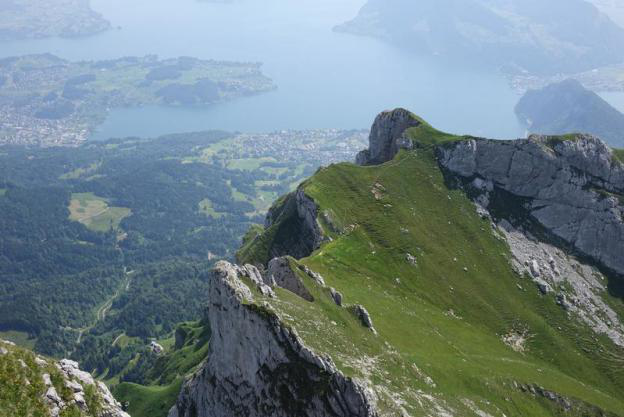

In [5]:
img_path = '/content/drive/My Drive/Deep_dream/test.jpg'
img0 = PIL.Image.open(img_path)
img0

# 執行deep_dream運算

In [6]:
# 原始圖片轉成np_array
img0 = PIL.Image.open(img_path)
img0 = np.float32(img0)

# 強化某通道輸出
#name = 'mixed4d_3x3_bottleneck_pre_relu'
#channel = 139
#layer_output = graph.get_tensor_by_name("import/%s:0" % name)
#render_deepdream(layer_output[:, :, :, channel], img0)

# 強化全通道輸出
name = 'mixed4c'
layer_output = graph.get_tensor_by_name("import/%s:0" % name)
render_deepdream(tf.square(layer_output), img0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
100%|██████████| 4/4 [00:08<00:00,  2.30s/it]

img saved: ./deepdream.jpg



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


# Deep_dream 結果

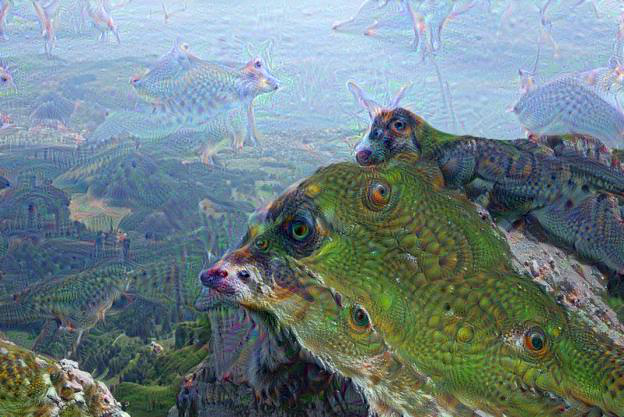

In [7]:
deep_dream_path = '/content/deepdream.jpg'
deep_dream = PIL.Image.open(deep_dream_path)
deep_dream